# Starter Code for Probabilistic Weather Prediction

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorchiefs/dlwbl_eth25/blob/master/internal/weather_pred.ipynb)

The data has been extracted from measurements of a DWD Station in Konstanz using the [Script](https://github.com/tensorchiefs/dlwbl_eth25/blob/master/internal/weather_data.R)


In [37]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
import torch # not needed yet

print(f'Keras_version: {keras.__version__}')# 3.5.0
print(f'torch_version: {torch.__version__}')# 2.5.1+cu121
print(f'keras backend: {keras.backend.backend()}')

Keras_version: 3.8.0
torch_version: 2.5.1
keras backend: torch


In [36]:
## Download the files from Dropbox to the local directory if they are not already there
# The files are:
# https://www.dropbox.com/scl/fi/3htpqzo16kwyxl3341j3x/DWD_lead_time24_max_lag48_Times.csv?rlkey=paudy33ut9yl2cmjmzsu15bm8&dl=0
# https://www.dropbox.com/scl/fi/8k5p5ynj015mtnfbkoo98/DWD_lead_time24_max_lag48_X.csv?rlkey=7oia5bnd93s11eyvgug7tgkjr&dl=0
# https://www.dropbox.com/scl/fi/p9aymv2jby1at26ng6w4g/DWD_lead_time24_max_lag48_y.csv?rlkey=mqp9ls9rorix1pu9r19tbxq67&dl=0
# The internal dropbox path is DL_WBL/HS24_25_WBL/Projekte/wetter/DWD_lead_time24_max_lag48_X.csv ...



import os
import requests

# URLs of the Dropbox files
files = {
    "DWD_lead_time24_max_lag48_Times.csv": "https://www.dropbox.com/scl/fi/3htpqzo16kwyxl3341j3x/DWD_lead_time24_max_lag48_Times.csv?rlkey=paudy33ut9yl2cmjmzsu15bm8&dl=1",
    "DWD_lead_time24_max_lag48_X.csv": "https://www.dropbox.com/scl/fi/8k5p5ynj015mtnfbkoo98/DWD_lead_time24_max_lag48_X.csv?rlkey=7oia5bnd93s11eyvgug7tgkjr&dl=1",
    "DWD_lead_time24_max_lag48_y.csv": "https://www.dropbox.com/scl/fi/p9aymv2jby1at26ng6w4g/DWD_lead_time24_max_lag48_y.csv?rlkey=mqp9ls9rorix1pu9r19tbxq67&dl=1"
}

# Directory to save the files
save_dir = "./data"
os.makedirs(save_dir, exist_ok=True)

# Download files if they don't already exist
for file_name, url in files.items():
    file_path = os.path.join(save_dir, file_name)
    if not os.path.exists(file_path):
        print(f"Downloading {file_name}...")
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(file_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=1024):
                    f.write(chunk)
            print(f"{file_name} downloaded successfully.")
        else:
            print(f"Failed to download {file_name}. Status code: {response.status_code}")
    else:
        print(f"{file_name} already exists. Skipping download.")



DWD_lead_time24_max_lag48_Times.csv downloaded successfully.
DWD_lead_time24_max_lag48_X.csv downloaded successfully.
DWD_lead_time24_max_lag48_y.csv downloaded successfully.


In [40]:
### reading csv file from 
import pandas as pd
X = pd.read_csv('data/DWD_lead_time24_max_lag48_X.csv')
y = pd.read_csv('data/DWD_lead_time24_max_lag48_y.csv')
times_sec = pd.read_csv('data/DWD_lead_time24_max_lag48_Times.csv')
#Times are stored in seconds since 1970-01-01 00:00:00

print(X.iloc[0:5, 0:3])
print(y.head())
print(times_sec.head())

# Transfer times to datetime
times = pd.to_datetime(times_sec['times'], unit="s", utc=True)

# Convert to numpy array
X = X.to_numpy()
y = y.to_numpy()


X_train = X[:int(0.8*len(X))]
y_train = y[:int(0.8*len(y))]
X_test = X[int(0.8*len(X)):]
y_test = y[int(0.8*len(y)):]

X_train.shape, y_train.shape #((10503, 96), (10503, 1))

   TT_TU.Lufttemperatur.lag_48  TT_TU.Lufttemperatur.lag_47  \
0                         10.3                         10.1   
1                         10.1                          9.6   
2                          9.6                          9.5   
3                          9.5                          9.7   
4                          9.7                         10.7   

   TT_TU.Lufttemperatur.lag_46  
0                          9.6  
1                          9.5  
2                          9.7  
3                         10.7  
4                         12.5  
      y
0  16.8
1  18.4
2  18.4
3  18.3
4  17.8
        times
0  1690671600
1  1690675200
2  1690678800
3  1690682400
4  1690686000


((10503, 96), (10503, 1))

In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Create a simple model without hidden layers
model = Sequential([
    Dense(units=1, input_dim=X_train.shape[1], activation='linear')  # No hidden layers
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50


/Users/oli/Documents/GitHub/dlwbl_eth25/env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 489.2942 - mae: 14.2664 - val_loss: 45.6977 - val_mae: 5.4272
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 36.7139 - mae: 4.7620 - val_loss: 27.3096 - val_mae: 4.1787
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 26.4435 - mae: 4.0834 - val_loss: 31.0032 - val_mae: 4.4608
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 21.8599 - mae: 3.6964 - val_loss: 18.6445 - val_mae: 3.4133
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 18.5555 - mae: 3.4047 - val_loss: 15.7086 - val_mae: 3.1306
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 19.1999 - mae: 3.4641 - val_loss: 14.5251 - val_mae: 3.0179
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 20.8404 - mae: 3.6465 - val_loss: 14.2590 - val_mae: 3.0054
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 16.9361 - mae: 3.2950 - val_loss: 13.0829 - val_mae: 2.8474
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/st

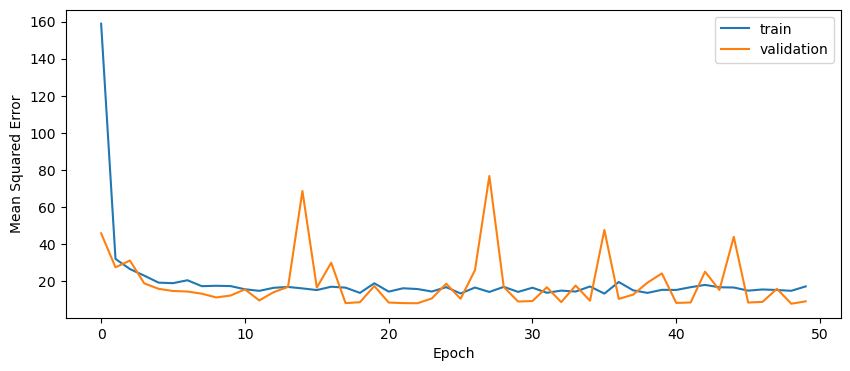

In [34]:
# Plot Learning Curves
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Test Loss (MSE): 10.527143478393555
Test MAE: 2.673415184020996
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step


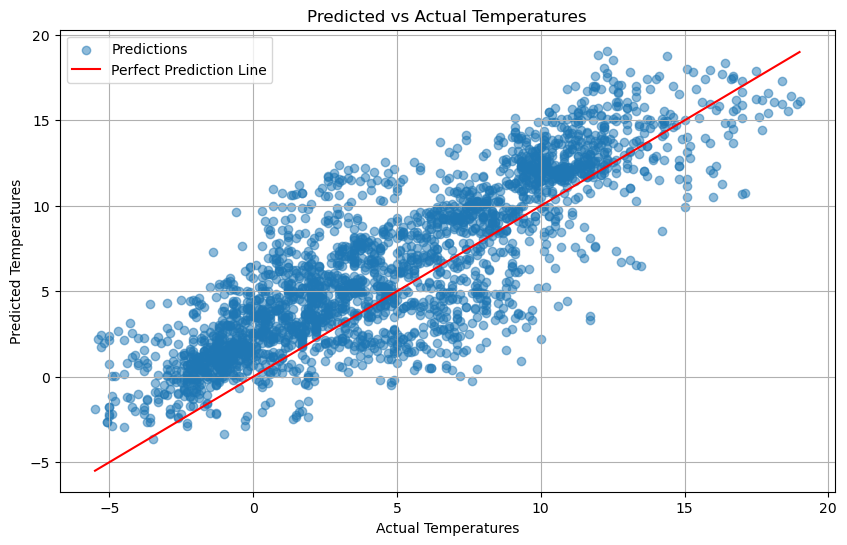

Test RMSE: 3.244555835401769


In [35]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss}")
print(f"Test MAE: {mae}")

# Predict on test data
y_pred = model.predict(X_test)

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Perfect Prediction Line')
plt.title("Predicted vs Actual Temperatures")
plt.xlabel("Actual Temperatures")
plt.ylabel("Predicted Temperatures")
plt.legend()
plt.grid()
plt.show()

# Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")